In [1]:
import os
import io
import numpy as np
from PIL import Image
import fitz
import re

from faster_rcnn import BradOCR, plot_text_xyxy
from ocr_post_process import group_text_into_line, find_single_passage

nt


- load model

In [2]:
ocr_model = BradOCR(
    filepath_model_word=os.path.join(r'C:\Users\bomso\bomsoo1\python\_pytorch\pjt_faster_rcnn\trained\word\fasterrcnn_01010320_0.9651181492864416'), # resnet
    filepath_model_char=os.path.join(r'C:\Users\bomso\bomsoo1\python\_pytorch\pjt_faster_rcnn\trained\char\fasterrcnn_01270246_0.9668653988020294'),  # pjt_faster_rcnn_250126_OCR_CHAR3_0p5 vgg
    n_test_pre_nms_WORD=12000, n_test_post_nms_WORD=2000,
    n_test_pre_nms_CHAR=600, n_test_post_nms_CHAR=100,
    label_names_char = list('''0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ~!@#$%^&*()_+-={}|[]\:";'<>?,./'''), # full except: `
)

>> reloaded_word['model_init_inputs'] = {'n_fg_class': 1, 'feat_stride': 16, 'loc_normalize_mean': (0.0, 0.0, 0.0, 0.0), 'loc_normalize_std': (0.1, 0.1, 0.2, 0.2), 'backbone_name': 'resnet101', 'use_pretrained_weights': True, 'freeze_param_up_to': 0, 'ceil_mode_for_MaxPool2d': True, 'always_freeze_first_batch_norm': False, 'use_untrained_vgg_classifier': False, 'base_size': 16, 'ratios': [0.25, 0.5, 1, 2, 4], 'anchor_scales': [0.25, 0.5, 1, 2, 4], 'y_offsets': [0], 'x_offsets': [0], 'nms_thresh': 0.7, 'n_train_pre_nms': 12000, 'n_train_post_nms': 2000, 'n_test_pre_nms': 12000, 'n_test_post_nms': 2000, 'min_size': 0, 'roi_size': 7, 'is_roi_align': True, 'roi_align_sampling_ratio': 2, 'roi_align_aligned': True}
>> reloaded_char['model_init_inputs'] = {'n_fg_class': 93, 'feat_stride': 16, 'loc_normalize_mean': (0.0, 0.0, 0.0, 0.0), 'loc_normalize_std': (0.1, 0.1, 0.2, 0.2), 'backbone_name': 'vgg16', 'use_pretrained_weights': True, 'freeze_param_up_to': 0, 'ceil_mode_for_MaxPool2d': True, 

- load image / detect text

[████████████████████████████████████████████████████████████] 22/22, elapsed time 00:09.4, estimated wait time 00:00.00



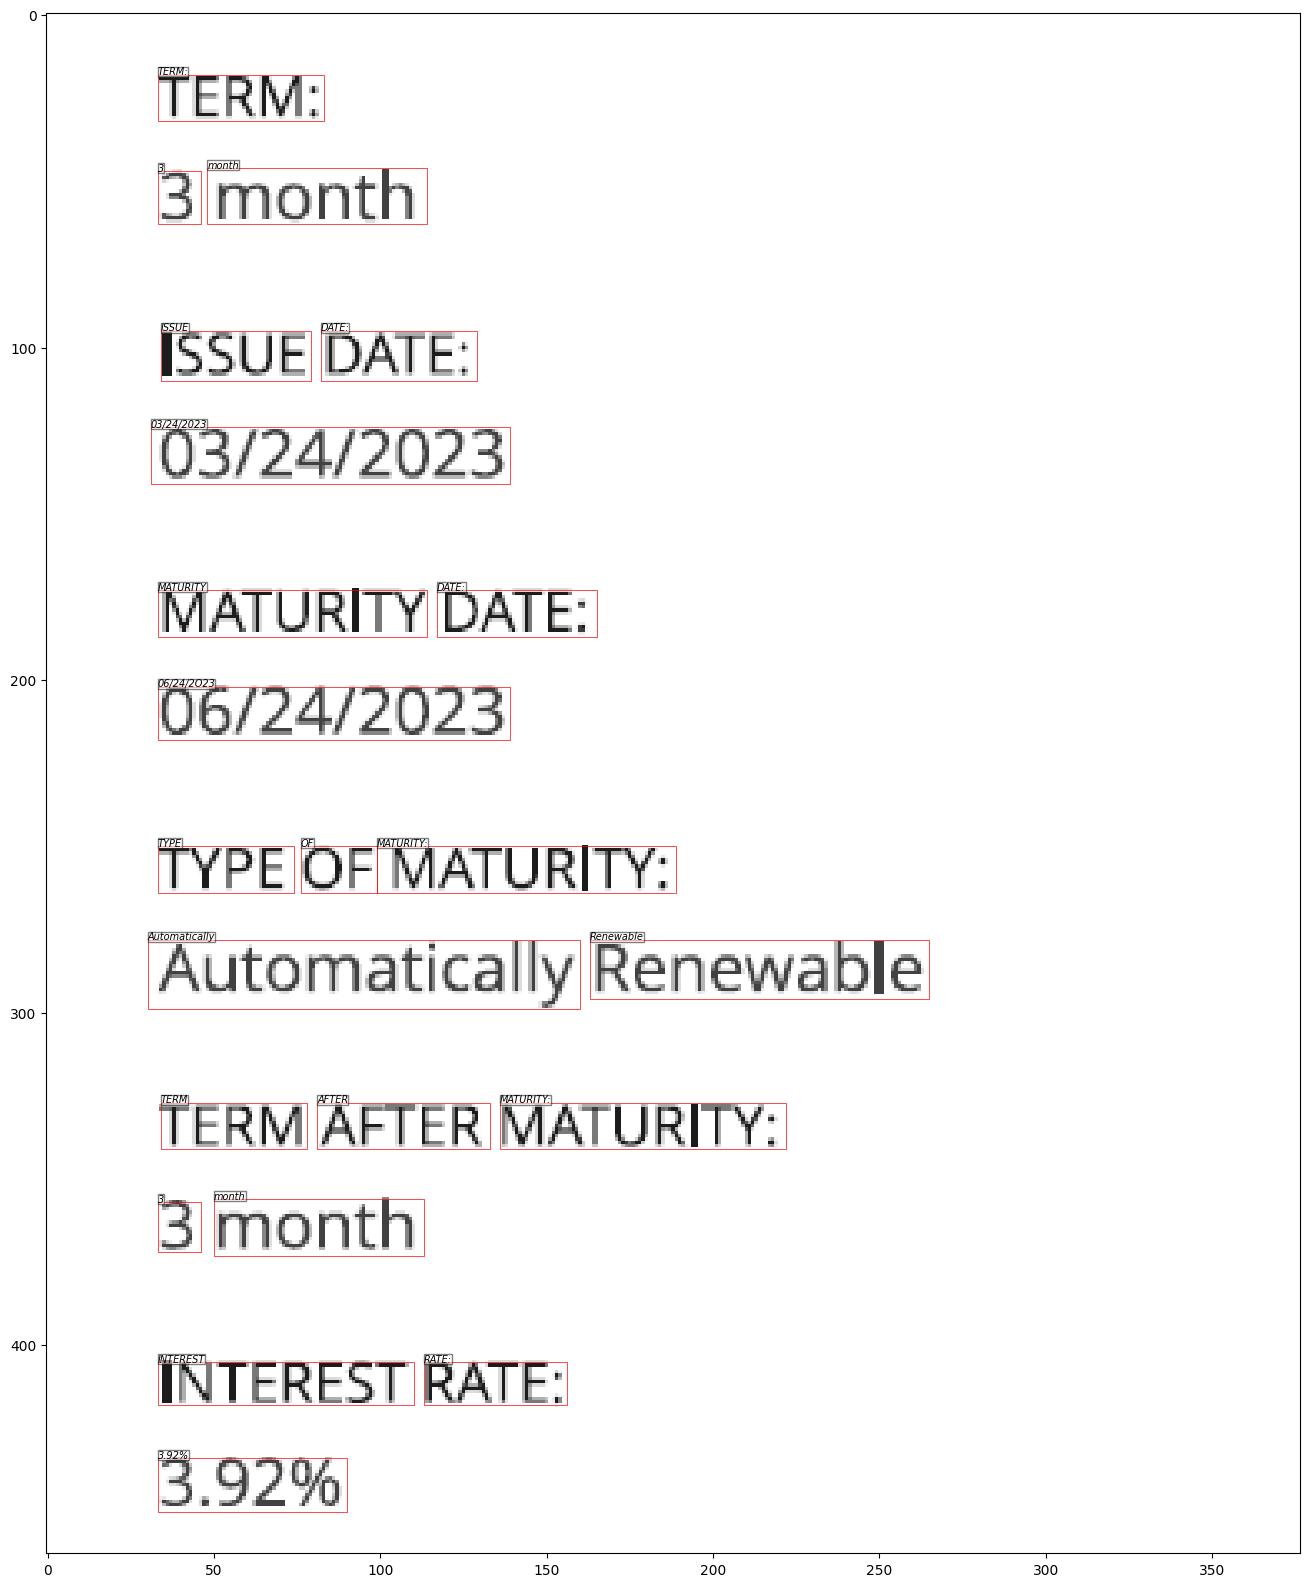

TERM:
3 month
ISSUE DATE:
03/24/2023
MATURITY DATE:
06/24/2O23
TYPE OF MATURITY:
Automatically Renewable
TERM AFTER MATURITY:
3 month
INTEREST RATE:
3.92%
[████████████████████████████████████████████████████████████] 81/81, elapsed time 00:45.0, estimated wait time 00:00.00



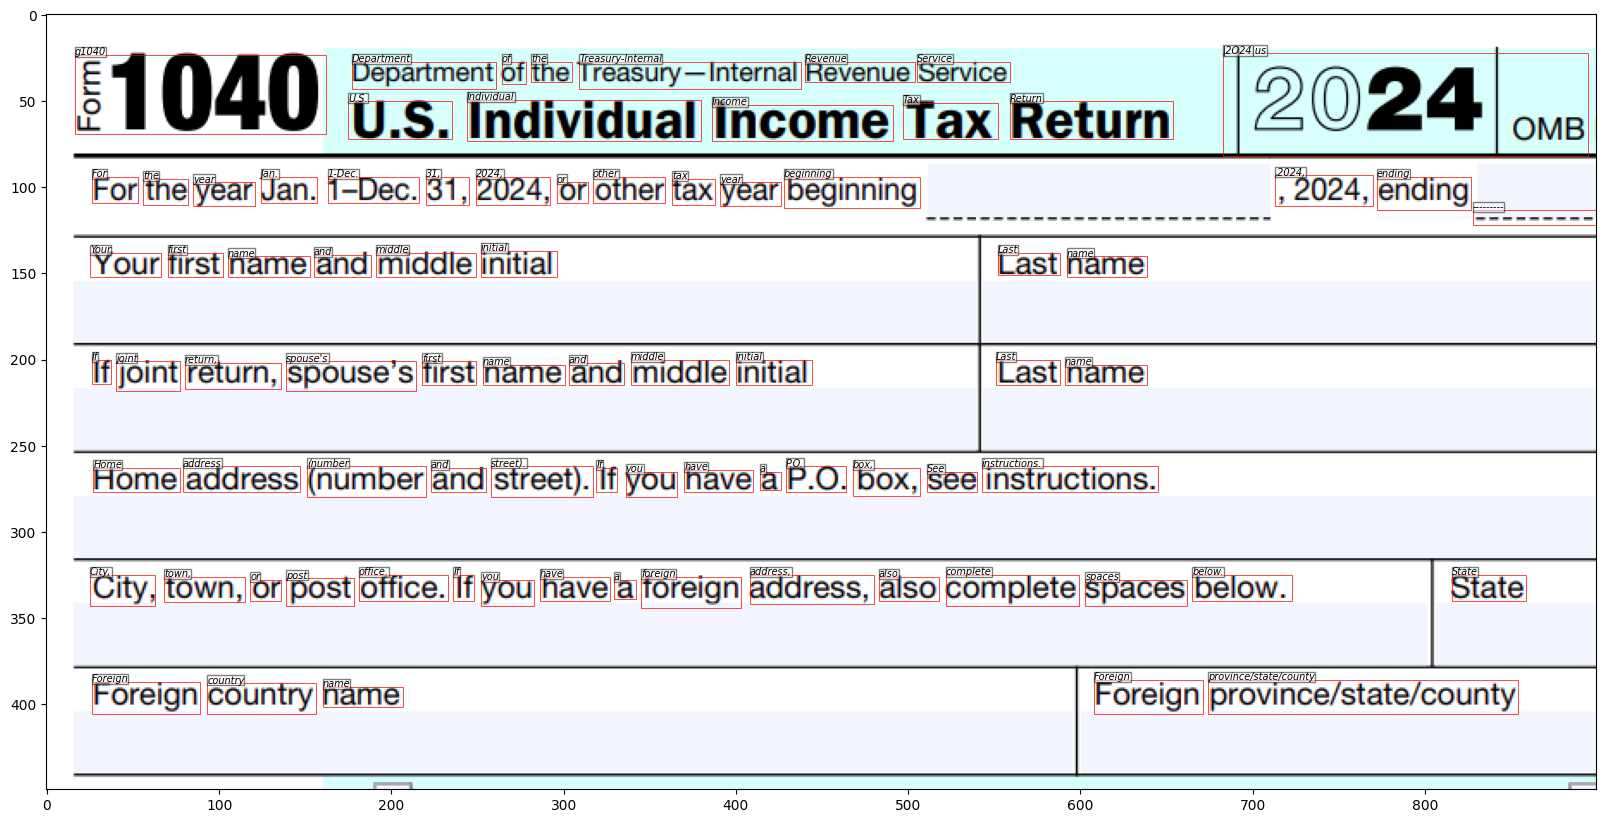

of the Treasury-lnternal Revenue Service	Department g1040 U.S. Individual Income Tax Return |2O24|us
For the year Jan. 1-Dec. 31, 2024, or other tax year beginning	,2024, ending
---------
Your first name and middle initial	Last name
If joint return, spouse's first name and middle initial	Last name
Home address (number and street). If you have a P.O. box, See instructions.
a	City, town, or post office. If you have foreign address, also complete spaces below.	State
Foreign country name	Foreign province/state/county
[████████████████████████████████████████████████████████████] 92/92, elapsed time 00:42.8, estimated wait time 00:00.00



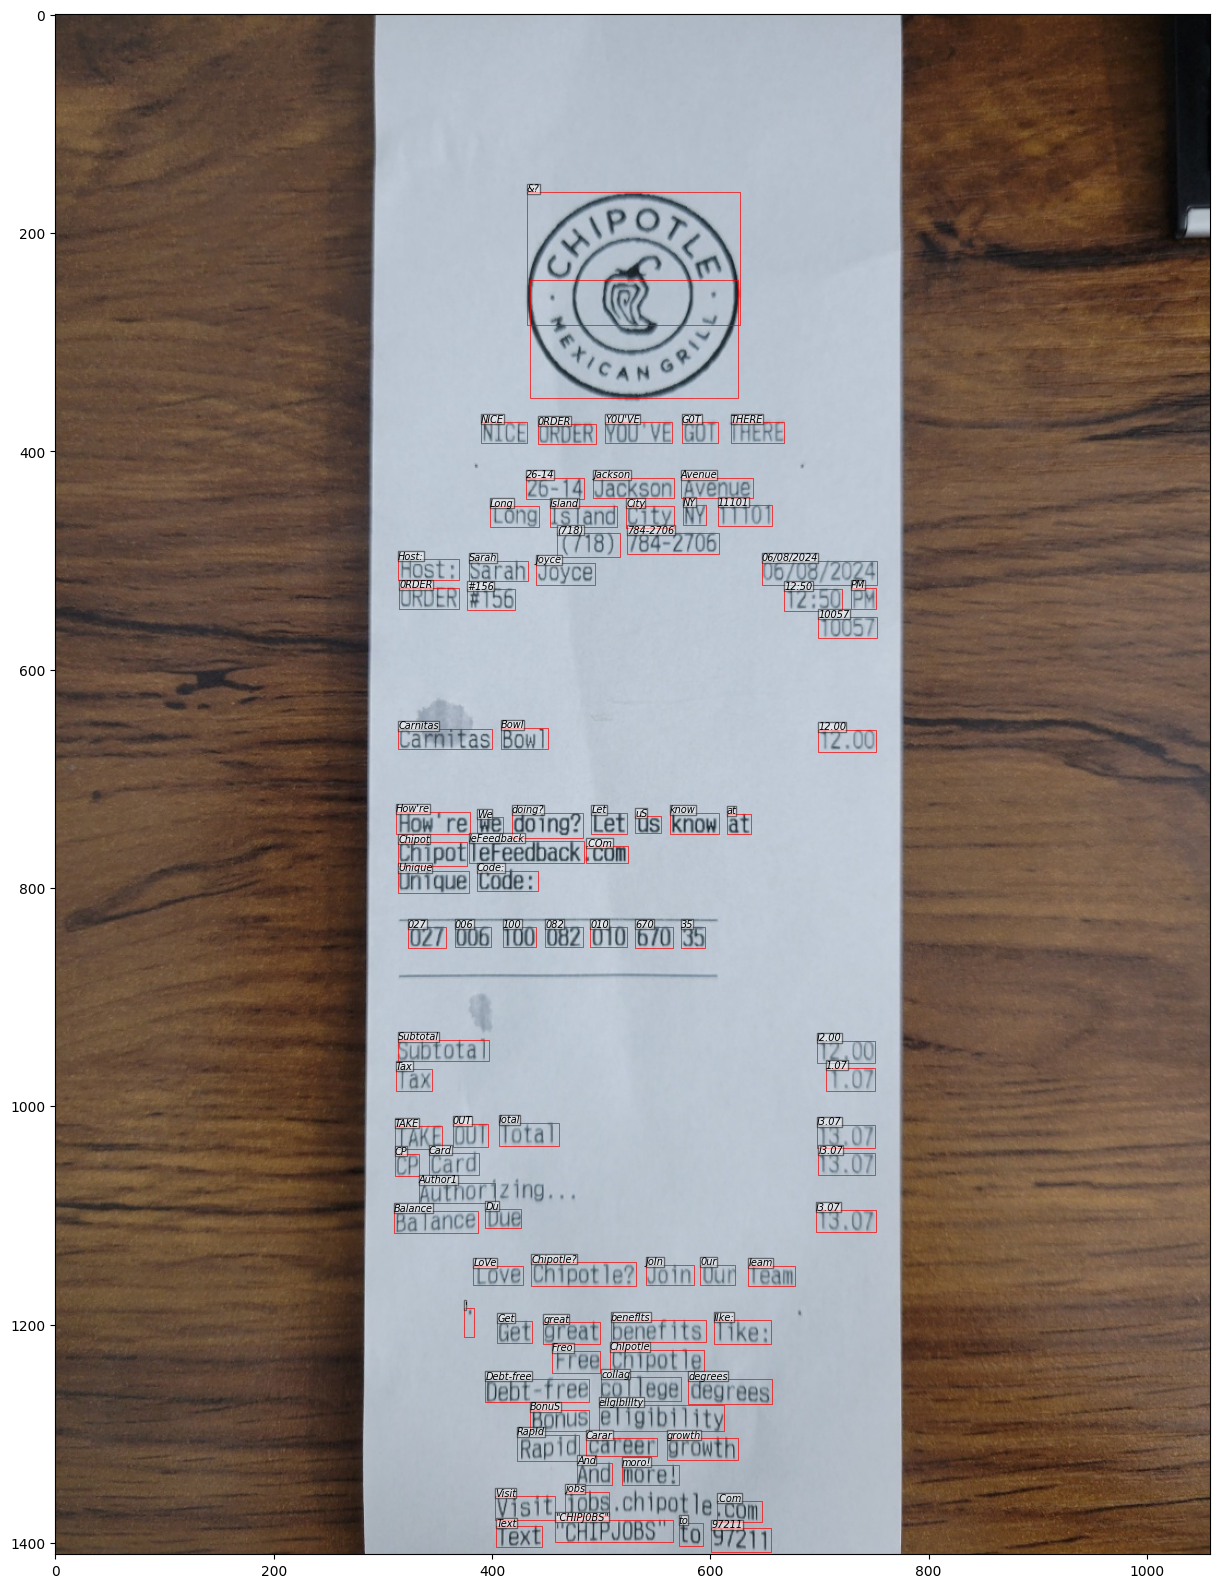

&?
NICE 0RDER Y0U'VE G0T THERE
26-14 Jackson Avenue
Long Island City NY 11101
(718) 784-2706
Host: Sarah Joyce	06/08/2024
0RDER #156	12:50 PM
10057
Carnitas Bowl	12.00
How're We doing? Let uS know at
Chipot leFeedback .COm
Unique Code:
027 006 100 082 010 670 35
Subtotal	I2.00
Tax	1.07
TAKE 0UT Iotal	I3.07
CP Card	I3.07
Author1
Balance Du	I3.07
LoVe Chipotle? JoIn 0ur Ieam
'	Get great benefIts IIke:
Freo ChIpotle
Debt-free coIlag degrees
BonuS elIgIbIIIty
RapId Carar growth
And moro!
Visit jobs	.Com
Text "CHIPJ0BS" to 97211


In [3]:
for filepath in [
    r'images/pic05.png',
    r'images/1040.png',
    r'images/chipotle.jpg',
]:
    #--- load image ---------------------------------------------------
    if re.search('\.(jpg|png)$', filepath, re.IGNORECASE): # load image file
        image = Image.open(filepath)
        if image.mode != 'RGB':
            image = image.convert("RGB")
        img = np.array(image)
    elif re.search('\.pdf$', filepath, re.IGNORECASE): # load pdf file
        doc = fitz.open(os.path.join(filepath)) # Open the PDF document
        page = doc[0] # Get the first page
        # pix = page.get_pixmap(dpi=300) # Get the pixmap of the page
        pix = page.get_pixmap(dpi=150) # Get the pixmap of the page
        img_bytes = pix.tobytes() # Convert the pixmap to bytes
        img = np.array(Image.open(io.BytesIO(img_bytes))) # Open the image using PIL
    else:
        raise(Exception(f'Brad error: unknown file extension...'))

    #--- predict -----------------------------------------------------
    # out = {'pred_texts': [('PERMANENT', (95, 610, 187, 623)),.......
    out = ocr_model.predict(img, fix_img_H=100, debug=False)

    #--- post-process ------------------------------------------------
    list_text_xyxy = out['pred_texts']
    i_to_line_map, seqs, uid_to_word_map = group_text_into_line(list_text_xyxy, alpha=1.0, debug=False)
    passage, longlines = find_single_passage(seqs, uid_to_word_map, delimiter='\t')
    # passage, longlines = find_single_passage(seqs, uid_to_word_map, delimiter=';')

    #--- plot bounding box -------------------------------------------
    plot_text_xyxy(img, out['pred_texts'])
    # plot_text_xyxy(img, i_to_line_map.values())
    # plot_text_xyxy(img, passage)

    print('\n'.join(p[0] for p in passage)) # text extracted

